# Variational Autoencoder

In [1]:
using Knet
using NNHelferlein, CUDA
using Images

┌ Info: Precompiling NNHelferlein [b9e938e5-d80d-48a2-bb0e-6649b4a98aeb]
└ @ Base loading.jl:1423


### Data
Load images from directory, flatten the 64x64x3 tensors to a vecor and
build a matrix with 12288 rows (= RGB-values of all pixels) and 
5 columns (= number of pictures).

,,,,

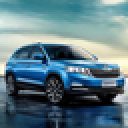
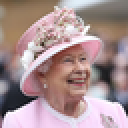
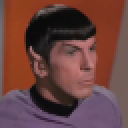
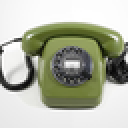
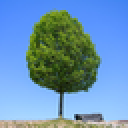

In [2]:
d = joinpath(NNHelferlein.DATA_DIR, "Images64")
imgs = [load(joinpath(d, i)) for i in readdir(d) if occursin("png", i)]

In [3]:
trn = hcat(vec.(image2array.(imgs))...)
trn = convert2KnetArray(trn)
size(trn)

(12288, 5)

This is how the vectors can be transformed into pictures again (array2image() is from the NNHelferlein-API): 

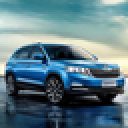

In [4]:
array2image(reshape(trn[:,1], 64,64,3))

## The VAE

### encoder and decoder 

are defined as as multi-layer perceptrons (encoder output is twice the size of decoder 
input because of the need for mean and variance for each of the VAE codes):

In [5]:
actf = relu
encoder = Chain(
    Dense(64*64*3, 512, actf=actf),
    Dense(512, 64, actf=actf),
    Dense(64, 16, actf=identity))

decoder = Chain(
    Dense(8, 64, actf=actf),
    Dense(64, 512, actf=actf),
    Dense(512, 64*64*3, actf=identity))

vae = VAE(encoder, decoder)

VAE(Chain[Chain((Dense(P(Knet.KnetArrays.KnetMatrix{Float32}(512,12288)), P(Knet.KnetArrays.KnetVector{Float32}(512)), Knet.Ops20.relu), Dense(P(Knet.KnetArrays.KnetMatrix{Float32}(64,512)), P(Knet.KnetArrays.KnetVector{Float32}(64)), Knet.Ops20.relu), Dense(P(Knet.KnetArrays.KnetMatrix{Float32}(16,64)), P(Knet.KnetArrays.KnetVector{Float32}(16)), identity))), Chain((Dense(P(Knet.KnetArrays.KnetMatrix{Float32}(64,8)), P(Knet.KnetArrays.KnetVector{Float32}(64)), Knet.Ops20.relu), Dense(P(Knet.KnetArrays.KnetMatrix{Float32}(512,64)), P(Knet.KnetArrays.KnetVector{Float32}(512)), Knet.Ops20.relu), Dense(P(Knet.KnetArrays.KnetMatrix{Float32}(12288,512)), P(Knet.KnetArrays.KnetVector{Float32}(12288)), identity)))])

In [6]:
print_network(vae)

Neural network summary:
VAE with 2 layers,                                            12663440 params
Details:
 
    Chain with 3 layers,                                       6325840 params
 
        Dense layer 12288 → 512 with relu,                     6291968 params
        Dense layer 512 → 64 with relu,                          32832 params
        Dense layer 64 → 16 with identity,                        1040 params
 
    Chain with 3 layers,                                       6337600 params
 
        Dense layer 8 → 64 with relu,                              576 params
        Dense layer 64 → 512 with relu,                          33280 params
        Dense layer 512 → 12288 with identity,                 6303744 params
 
 
Total number of layers: 6
Total number of parameters: 12663440


6

### Training:

Alle images are stored as one minibatch, with the input also used as teaching input (i.e. x == y).    
The training is done with a (likely too) high number of epochs and a small learning rate, in order to get best possible
reconstruction (to the cost of massive overfitting).

In [7]:
mbs = minibatch(trn, trn, 5)

1-element Knet.Train20.Data{Tuple{KnetArray{Float32}, KnetArray{Float32}}}

In [8]:
vae(trn, trn)

10999.375f0

Progress: 100%|█████████████████████████████████████████| Time: 0:02:29m


Training 10000 epochs with 1 minibatches/epoch
    (and 1 validation mbs).
Evaluation is performed every 1 minibatches (with 1 mbs).
Watch the progress with TensorBoard at: /home/andreas/.julia/dev/NNHelferlein/examples/logs/run/2021-12-19T10-52-01
Training finished with:
Training loss:       43.200439453125
Validation loss:     42.979183197021484


,,,,

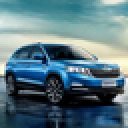
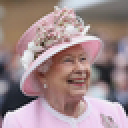
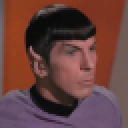
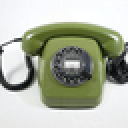
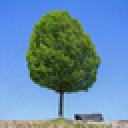

In [9]:
tb_train!(vae, Adam, mbs, mbs, epochs=10000, lr=0.0001)
y = vae(trn)
[array2image(reshape(y[:,i], 64,64,3)) for i in 1:5]

### Experiments:

In [10]:
code_car = encoder(trn[:,1])[1:8]
code_tree = encoder(trn[:,5])[1:8]
code_spock = encoder(trn[:,3])[1:8]

8-element Knet.KnetArrays.KnetVector{Float32}:
  1.3032044
 -0.96112514
 -0.20283177
 -0.76469904
 -0.70002204
 -0.13171624
  0.003861934
  0.652173

,

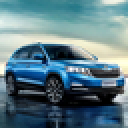
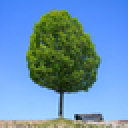

In [11]:
[array2image(reshape(decoder(code_car), 64,64,3)),
 array2image(reshape(decoder(code_tree), 64,64,3))]

This is the ability of a variational autoencoder:   
even the highly overfitted autoencoder has a perfectly regularised codebook and 
interpolates perfectly between trained patterns!

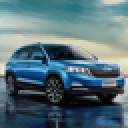

In [12]:
array2image(reshape(decoder(code_car*0.8 + code_tree*0.2), 64,64,3))

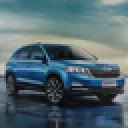

In [13]:
array2image(reshape(decoder(code_car*0.6 + code_tree*0.4), 64,64,3))

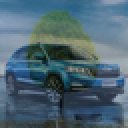

In [14]:
array2image(reshape(decoder(code_car*0.5 + code_tree*0.5), 64,64,3))

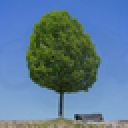

In [15]:
array2image(reshape(decoder(code_car*0.2 + code_tree*0.8), 64,64,3))

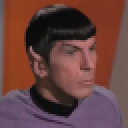

In [16]:
array2image(reshape(decoder(code_spock), 64,64,3))

fascinating!